In [1]:
import keras
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, Dropout, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import decode_predictions, preprocess_input
from scipy import spatial
from matplotlib.patches import Rectangle
from PIL import Image
import cv2
%matplotlib inline

Using TensorFlow backend.
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


In [2]:
#return distance between vector points
def vector_dist(v1, v2):
    #result = spatial.distance.cosine(dataSetI, dataSetII)
    return spatial.distance.cdist(v1, v2)

In [3]:
#return subarray from full image
def get_img_slice(t_img, x, y, model_width):
    t_array = t_img[x: x + model_width, y: y + model_width, :]
    return t_array

In [4]:
#return model
def get_model():
    res_model = ResNet50(include_top=False, weights = 'imagenet', input_shape = (224, 224, 3))
    max_pool = MaxPooling2D()(res_model.output)
    max_pool2 = MaxPooling2D()(max_pool)
    flat_1 = Flatten()(max_pool2)
    model = Model(inputs = res_model.inputs, outputs = flat_1)
    model.compile(optimizer = 'rmsprop', loss = "categorical_crossentropy", metrics = ['accuracy'])
    return model

In [5]:
#return prediction
def get_pred(t_img):
    t_test = image.img_to_array(t_img)
    t_test = np.expand_dims(t_test, axis=0)
    t_test = preprocess_input(t_test)
    return model.predict(t_test)

In [6]:
#return value from x/y index
def return_xy(randx, randy, idx):
    t_x = randx[idx : idx + 1]
    t_y = randy[idx : idx + 1]
    return int(t_x), int(t_y)

In [7]:
#random search returns x, y coordinates
def random_search(img, x_start, x_finish, y_start, y_finish):
    num_samples = 500
    rand_x = np.random.randint(x_start, x_finish, num_samples)
    rand_y = np.random.randint(y_start, y_finish, num_samples)
    dist_array = []
    for i in range(len(rand_x)):
        test_slice = get_img_slice(img, rand_x[i], rand_y[i], model_width)
        test_img = image.array_to_img(test_slice)
        dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
    return return_xy(rand_x, rand_y, np.argmin(dist_array))

In [8]:
def narrow_search(img, x_start, x_finish, y_start, y_finish):
    dist_array = []
    t_i = []
    t_j = []
    for i in range(x_start, x_finish):
        for j in range(y_start, y_finish):
            test_slice = get_img_slice(img, i, j, model_width)
            test_img = image.array_to_img(test_slice)
            dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
            t_i.append(i)
            t_j.append(j)
    
    return t_i[np.argmin(dist_array): np.argmin(dist_array) + 1][0], t_j[np.argmin(dist_array): np.argmin(dist_array) + 1][0] 

In [9]:
def target_search():
    x, y = random_search(tee_ny, x_start_num, x_finish_num, y_start_num, y_finish_num)
    x, y = random_search(tee_ny, x - 50, x + 50, y - 50, y + 50)
    x, y = narrow_search(tee_ny, x - 5, x + 6, y - 5, y + 6)
    return x, y

In [10]:
model_width = 224

In [11]:
model = get_model()

/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
#full image view and full image as array
img = image.load_img("ny_resized.jpg")
full_img = image.img_to_array(img)

/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (225000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


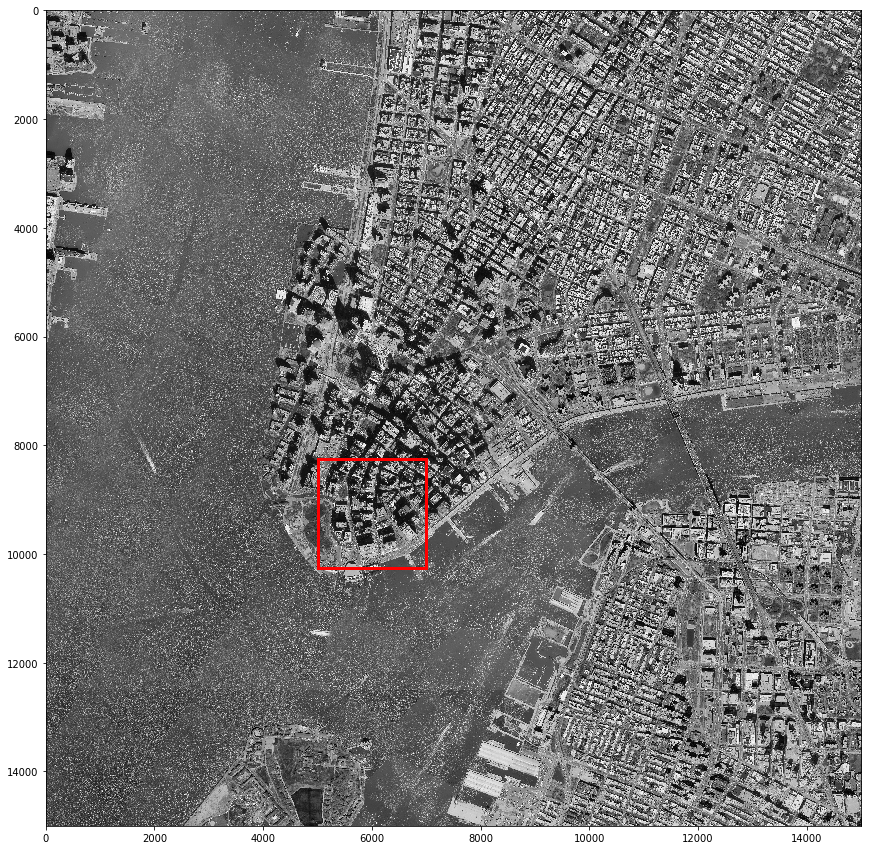

In [13]:
plt.figure(figsize = (15,15))
plt.gca().add_patch(Rectangle((5000, 8250),2000,2000,linewidth=3,edgecolor='r',facecolor='none'));
plt.imshow(np.asarray(img));

In [14]:
pixel_x = 712
pixel_y = 712

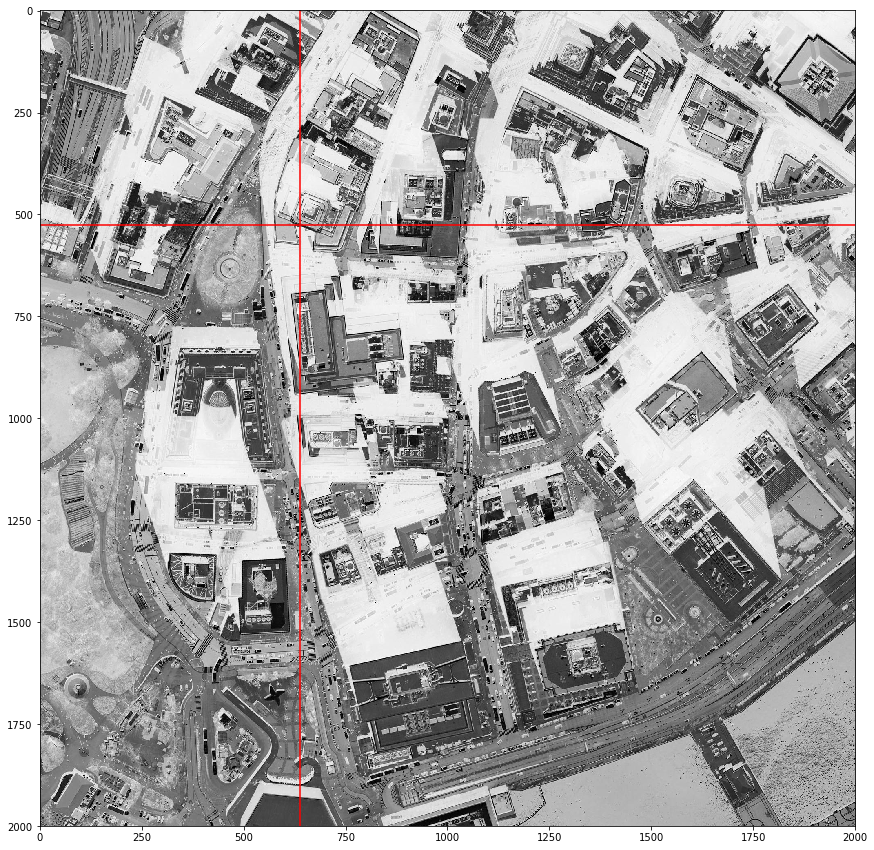

In [29]:
#return subarray from full image, arbitrarily chosen
tee_ny = full_img[8250 : 10250, 5000 :  7000, :]
tee_ny_img = image.array_to_img(tee_ny)
plt.figure(figsize = (15,15))
#plt.gca().add_patch(Rectangle((600,600),224,224,linewidth=3,edgecolor='r',facecolor='none'));
plt.axvline(x= 639, color= 'red')
#plt.axhline(y= 750, color= 'red')
plt.axhline(y= 526, color= 'red')
plt.imshow(tee_ny);

In [16]:
pixel_x = 600
pixel_y = 600

In [17]:
x_start_line = pixel_x
y_start_line = pixel_y
x_start_num = x_start_line - 112#model_width 
y_start_num = y_start_line - 112#model_width
x_finish_num = x_start_line + model_width + 112#(model_width*2)
y_finish_num = y_start_line + model_width + 112#(model_width*2)

(448, 448, 3)


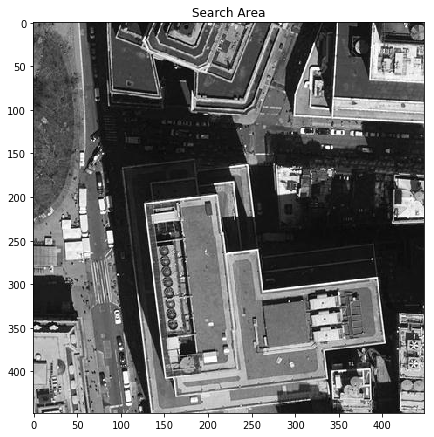

In [18]:
search_img = tee_ny[x_start_num:x_finish_num, y_start_num: y_finish_num]
print(search_img.shape)
search_img = image.array_to_img(search_img)
plt.figure(figsize = (7,10))
plt.title('Search Area')
#plt.axis('off')
plt.imshow(search_img);

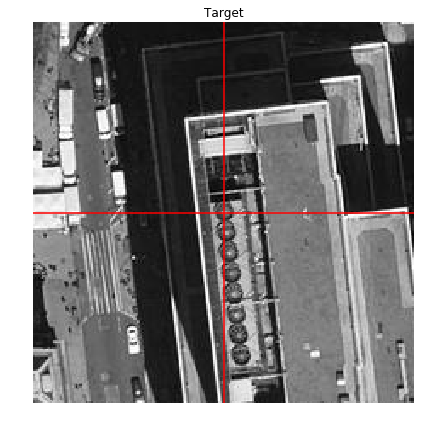

In [19]:
#Target Image and target to predict
x_img = image.img_to_array(tee_ny)
x_img_array = get_img_slice(x_img, x_start_line + 39, y_start_line - 74, model_width)
x_img = image.array_to_img(x_img_array)
goal_pred = get_pred(x_img)
plt.figure(figsize = (7,7))
plt.title('Target')
plt.axvline(x= model_width * .5, color= 'red')
plt.axhline(y= model_width * .5, color= 'red')
plt.axis('off')
plt.imshow(x_img);

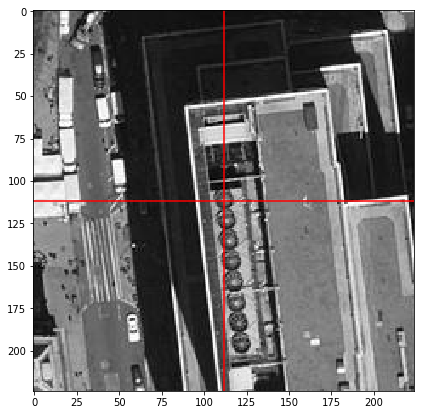

In [20]:
x, y = target_search() 
z_img = get_img_slice(tee_ny, x, y, model_width)
z_img = image.array_to_img(z_img)
plt.figure(figsize = (7,7))
plt.axvline(x = model_width * .5, color = 'red')
plt.axhline(y = model_width * .5, color = 'red')
plt.imshow(z_img);

In [21]:
x, y

(639, 526)

In [20]:
#plt.scatter(range(len(rand_x)), dist_array3, color = 'lightblue');

In [21]:
#plt.hist(dist_array3, color = 'lightblue');